In [1]:
import pyiron_workflow_atomistics.gb.gb_code.csl_generator as csl
from pyiron_workflow_atomistics.gb.gb_code.csl_generator import get_theta_m_n_list
import numpy as np
import pandas as pd
from math import degrees

from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_multiple_axes, get_gbcode_df
from pyiron_workflow_atomistics.gb.gb_code.constructor import construct_GB_from_GBCode

from pyiron_workflow_atomistics.dataclass_storage import CalcInputMinimize
from pyiron_workflow_lammps.engine import LammpsEngine
from pyiron_workflow import Workflow
from pyiron_workflow_atomistics.bulk import optimise_cubic_lattice_parameter
from ase.build import bulk

from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
from pyiron_workflow_atomistics.gb.analysis import plot_GB_plane, find_GB_plane
from pyiron_workflow_lammps.lammps import lammps_job
%load_ext autoreload
%autoreload 2

In [2]:
inp = CalcInputMinimize()
inp.relax_cell = False
Engine = LammpsEngine(EngineInput = inp)

Engine.working_directory = "test_opt_cubic_cell"
Engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
Engine.lammps_log_filepath = "minimize.log"
Engine.input_script_pair_style = "eam/fs"
Engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"

structure = bulk("Fe", a=2.828, cubic=True)
wf1 = Workflow(Engine.working_directory, delete_existing_savefiles=True)
wf1.opt_cubic_cell = optimise_cubic_lattice_parameter(
    structure=structure,
    name="Fe",
    crystalstructure="bcc",
    calculation_engine=Engine,
    parent_working_directory="opt_cubic_cell",
    rattle=0.1,
    strain_range=(-0.02, 0.02),
    num_points=6,
)
wf1.run()

test_opt_cubic_cell
test_opt_cubic_cell/strain_000


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


test_opt_cubic_cell/strain_001


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


test_opt_cubic_cell/strain_002


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


test_opt_cubic_cell/strain_003


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


test_opt_cubic_cell/strain_004


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


test_opt_cubic_cell/strain_005


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


{'opt_cubic_cell__equil_struct': Atoms(symbols='Fe2', pbc=True, cell=[2.8554036006730863, 2.8554036006730863, 2.8554036006730863], initial_magmoms=...),
 'opt_cubic_cell__a0': 2.8554036006730863,
 'opt_cubic_cell__B': 178.2689296133779,
 'opt_cubic_cell__equil_energy_per_atom': -4.012989682254272,
 'opt_cubic_cell__equil_volume_per_atom': 11.640523523888817,
 'opt_cubic_cell__volumes': [21.287097162601995,
  21.81268105404494,
  22.346845717919777,
  22.889660634165235,
  23.441195282719992,
  24.001519143522813],
 'opt_cubic_cell__structures': [Atoms(symbols='Fe2', pbc=True, cell=[[2.77144, 1.6970175625144705e-16, 1.6970175625144705e-16], [0.0, 2.77144, 1.6970175625144705e-16], [0.0, 0.0, 2.77144]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.794064, 1.7108707671064253e-16, 1.7108707671064253e-16], [0.0, 2.794064, 1.7108707671064253e-16], [0.0, 0.0, 2.794064]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.816688, 1.72472397169838e-16, 1.72472397169838e-16], [0.0, 2.816688, 1.724723971698

In [3]:
from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_multiple_axes
gbcode_df = get_gbcode_df_multiple_axes(axes_list=[np.array([1, 1, 1])],#, np.array([1, 1, 0]), np.array([1, 0, 0])],
                   basis="bcc",
                   sigma_limit=100,
                   lim_plane_index=3,
                   max_atoms=200,
                   max_workers=None)
from pyiron_workflow_atomistics.gb.gb_code.searcher import _deduplicate_gbcode_df_miller_indices_equivalent

gbcode_df_unique = _deduplicate_gbcode_df_miller_indices_equivalent(gbcode_df)
def make_gb_string(row):
    # strip parentheses/brackets, remove commas and spaces
    plane = str(row['GB1']).strip('()[]').replace(',', '').replace(' ', '')
    axis  = str(row['Axis']).strip('()[]').replace(',', '').replace(' ', '')
    return f"Sig_{row['Sigma']}_S({plane})_RA({axis})_{str(row['Type']).replace(' ', '')}"

gbcode_df_unique['GB_string'] = gbcode_df_unique.apply(make_gb_string, axis=1)
from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_with_structures
gbcode_df_unique_structures = get_gbcode_df_with_structures(df=gbcode_df_unique,
                                                            basis="bcc",
                                                            lattice_param=wf1.opt_cubic_cell.outputs.a0.value,
                                                            equil_volume_per_atom=wf1.opt_cubic_cell.outputs.equil_volume_per_atom.value,
                                                            req_length_grain=15,
                                                            min_inplane_gb_length=8,
                                                            grain_length_axis=0,
                                                            element="Fe",
                                                            max_workers=None)

def lattice_lengths(atoms):
    # get the 3×3 cell matrix
    cell = atoms.get_cell()        # or atoms.cell
    # length of each lattice vector
    return np.linalg.norm(cell[0]), np.linalg.norm(cell[1]), np.linalg.norm(cell[2])

# apply to the structure column and expand into a,b,c
gbcode_df_unique_structures[['a','b','c']] = gbcode_df_unique_structures['structure'] \
    .apply(lambda at: pd.Series(lattice_lengths(at), index=['a','b','c']))

# now df has columns a, b, c alongside everything else
gbcode_df_unique_structures

Constructing GB structures: 100%|██████████| 26/26 [00:04<00:00,  5.65it/s]


,Axis,Sigma,m,n,GB1,GB2,Theta (deg),Type,n_atoms,canon,dupe,GB_string,structure,structure_natoms,a,b,c
0,"[1, 1, 1]",3,3,1,"(-1, 1, 0)","(-1, 0, 1)",60.000000,Tilt,12,"((-1, -1, 0), (-1, 0, -1))",False,Sig_3_S(-110)_RA(111)_Tilt,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",384,9.891408,13.988564,32.305204
2,"[1, 1, 1]",3,3,1,"(1, 1, 1)","(1, 1, 1)",60.000000,Twist,12,"((-1, -1, -1), (-1, -1, -1))",False,Sig_3_S(111)_RA(111)_Twist,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",336,8.076301,13.988564,34.619929
7,"[1, 1, 1]",3,3,1,"(1, 0, 2)","(2, 0, 1)",60.000000,Mixed,180,"((-2, -1, 0), (-1, -2, 0))",False,Sig_3_S(102)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534,8.566211,19.154630,37.883601
8,"[1, 1, 1]",3,3,1,"(-1, 2, -1)","(-2, 1, 1)",60.000000,Symmetric Tilt,12,"((-2, -1, -1), (-1, -2, 1))",False,Sig_3_S(-12-1)_RA(111)_SymmetricTilt,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",288,9.891408,8.076301,41.965691
10,"[1, 1, 1]",3,3,1,"(2, 0, 1)","(2, 1, 0)",60.000000,Mixed,180,"((-2, -1, 0), (-2, 0, -1))",False,Sig_3_S(201)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534,8.566211,19.154630,37.883601
21,"[1, 1, 1]",3,3,1,"(0, 3, 0)","(-1, 2, 2)",60.000000,Mixed,72,"((-3, 0, 0), (-2, -2, -1))",False,Sig_3_S(030)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",284,8.076301,12.114451,33.788943
26,"[1, 1, 1]",3,3,1,"(-2, 3, -1)","(-3, 1, 2)",60.000000,Tilt,84,"((-3, -2, -1), (-2, 1, -3))",False,Sig_3_S(-23-1)_RA(111)_Tilt,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",672,9.891408,18.505130,42.735768
27,"[1, 1, 1]",3,3,1,"(3, 1, 2)","(3, 2, 1)",60.000000,Mixed,168,"((-3, -2, -1), (-3, -1, -2))",False,Sig_3_S(312)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",664,13.988564,13.085103,42.227009
28,"[1, 1, 1]",3,3,1,"(1, -1, 3)","(3, -1, 1)",60.000000,Mixed,132,"((-3, -1, -1), (-1, -3, -1))",False,Sig_3_S(1-13)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",1048,13.988564,23.197409,37.594231
29,"[1, 1, 1]",3,3,1,"(-2, -1, -3)","(-3, -1, -2)",60.000000,Mixed,168,"((-3, -2, -1), (-2, -3, -1))",False,Sig_3_S(-2-1-3)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",664,13.988564,13.085103,42.227009


pure_gb_study
pure_gb_study
pure_gb_study/gb_length_optimiser
pure_gb_study/gb_length_optimiser
pure_gb_study/gb_length_optimiser/ext_0.800


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_length_optimiser/ext_0.300


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_length_optimiser/ext_-0.200


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_length_optimiser
pure_gb_study/gb_length_optimiser/ext_0.050


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_length_optimiser/ext_0.025


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_length_optimiser/ext_0.000


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_length_optimiser/ext_-0.025


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_length_optimiser/ext_-0.050


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/gb_with_vacuum_rel


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


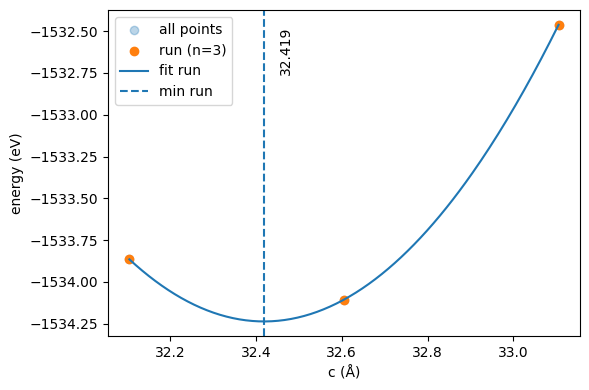

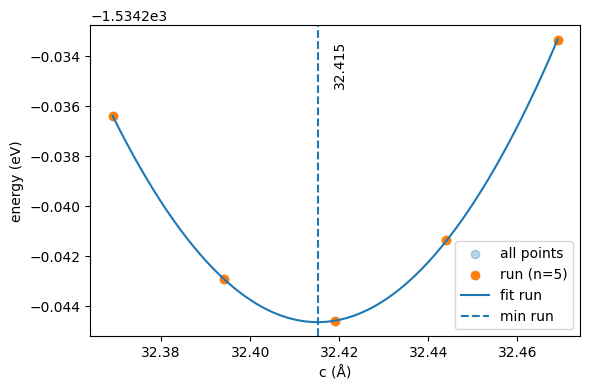

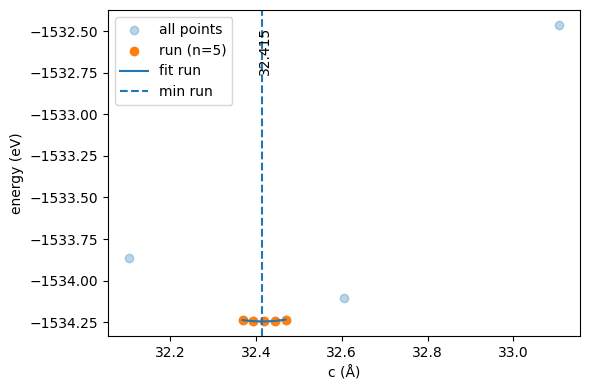

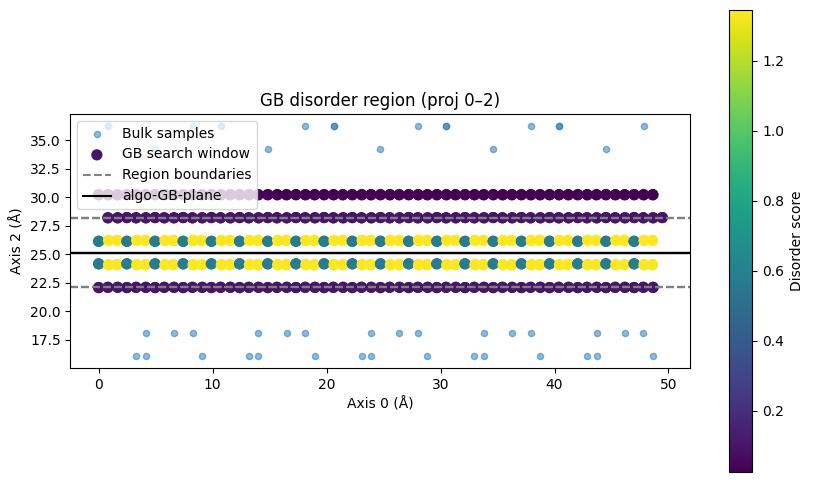

pure_gb_study/gb_seg_supercell


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study
pure_gb_study/cleavage_study
pure_gb_study/cleavage_study/cleavage_rigid
pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_27.165


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_25.107


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_23.078


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_21.07


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_relax
pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_27.165


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_25.107


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_23.078


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_21.07


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


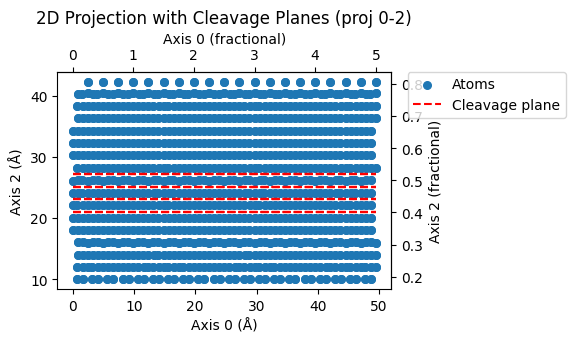

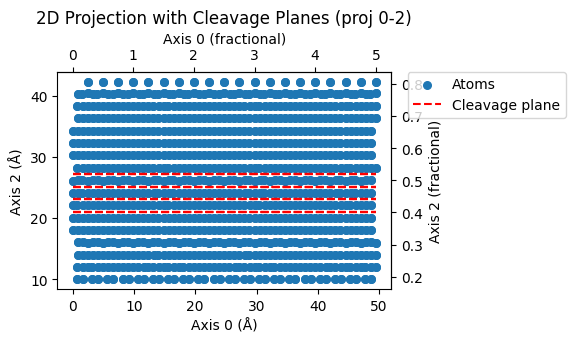

In [4]:
from pyiron_workflow_atomistics.dataclass_storage import CalcInputMinimize, CalcInputStatic
gb_study_list = []
for _, row in gbcode_df_unique_structures.head(1).iterrows():
    inp = CalcInputMinimize()
    inp.relax_cell = False
    gb_opt_engine = LammpsEngine(EngineInput = inp)
    gb_opt_engine.working_directory = "pure_gb_study"
    gb_opt_engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
    gb_opt_engine.lammps_log_filepath = "minimize.log"
    gb_opt_engine.input_script_pair_style = "eam/fs"
    gb_opt_engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"
    gb_opt_engine.input_script_dump_every = 100
    gb_opt_engine.input_script_dump_filename = "dump.out"
    
    gb_opt_engine_static = LammpsEngine(EngineInput=CalcInputStatic())
    gb_opt_engine_static.working_directory = "pure_gb_study"
    gb_opt_engine_static.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log static.log"
    gb_opt_engine_static.lammps_log_filepath = "static.log"
    gb_opt_engine_static.input_script_pair_style = "eam/fs"
    gb_opt_engine_static.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"
    from pyiron_workflow_atomistics.gb.gb_study import pure_gb_study
    from pyiron_workflow_atomistics.gb.dataclass_storage import CleaveGBStructureInput, PlotCleaveInput
    from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
    gb_study = pure_gb_study(
                    gb_structure = row["structure"],
                    equil_bulk_volume = wf1.opt_cubic_cell.outputs.equil_volume_per_atom.value,
                    equil_bulk_energy = wf1.opt_cubic_cell.outputs.equil_energy_per_atom.value,
                    extensions_stage1 = np.linspace(-0.2, 0.8, 3),
                    extensions_stage2 = np.linspace(-0.05, 0.05, 5),
                    calculation_engine = gb_opt_engine,
                    static_calculation_engine = gb_opt_engine_static,
                    length_interpolate_min_n_points=5,
                    gb_normal_axis="c",
                    vacuum_length=20,
                    min_inplane_cell_lengths=[6, 6, None],
                    featuriser = voronoiSiteFeaturiser,
                    approx_frac = 0.5,
                    tolerance = 5.0,
                    bulk_offset = 10.0,
                    slab_thickness = 2.0,
                    featuriser_kwargs = None,
                    n_bulk = 10,
                    threshold_frac = 0.3,
                    CleaveGBStructure_Input=CleaveGBStructureInput(tol=0.3),
                    PlotCleave_Input=PlotCleaveInput())()
    
    # gb_study_list.append(gb_study)


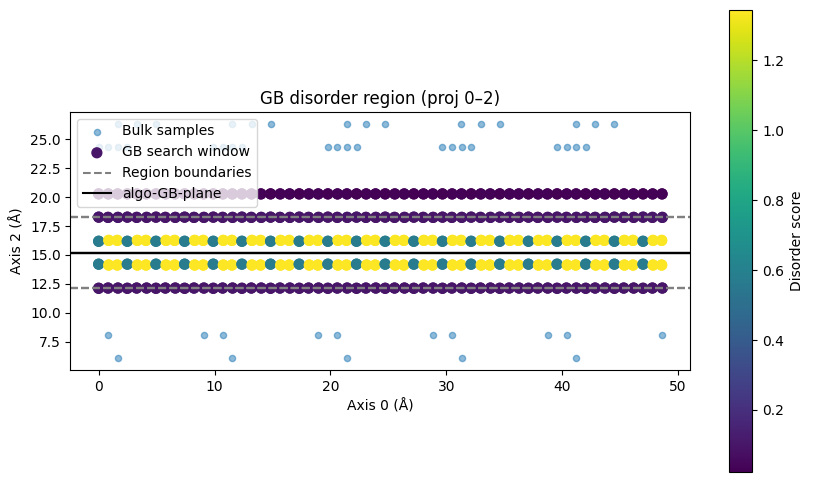

{'gb_plane_extractor_plot__fig': <Figure size 1000x600 with 2 Axes>,
 'gb_plane_extractor_plot__ax': <Axes: title={'center': 'GB disorder region (proj 0–2)'}, xlabel='Axis 0 (Å)', ylabel='Axis 2 (Å)'>}

In [5]:

# from pyiron_workflow_lammps.dataclass_storage import LammpsInput
# from pyiron_workflow_lammps.calculator import lammps_calculator_node

gb_opt_engine = LammpsEngine(EngineInput = inp)
gb_opt_engine.working_directory = "pure_gb_study"
gb_opt_engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
gb_opt_engine.lammps_log_filepath = "minimize.log"
gb_opt_engine.input_script_pair_style = "eam/fs"
gb_opt_engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"
gb_opt_engine.input_script_dump_every = 100
gb_opt_engine.input_script_dump_filename = "dump.out"

wf2 = Workflow("gb_seg_lammps", delete_existing_savefiles=True)
wf2.gb_plane_extractor = find_GB_plane(atoms = gb_study["final_pure_grain_boundary_structure"],
                                        featuriser = voronoiSiteFeaturiser,
                                        axis = "c",
                                        approx_frac = 0.5,
                                        tolerance = 5.0,
                                        bulk_offset = 10.0,
                                        slab_thickness = 2.0,
                                        featuriser_kwargs = {},
                                        n_bulk = 10,
                                        threshold_frac = 0.3
                                      )
wf2.gb_plane_extractor_plot = plot_GB_plane(atoms = gb_study["final_pure_grain_boundary_structure"],
                                            res = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict,
                                            projection=(0, 2),
                                            reps=(5, 1),
                                            figsize=(10, 6),
                                            bulk_color='C0',
                                            window_cmap='viridis',
                                            plane_linestyles=('--', '-'),
                                            axis=2,
                                            dpi=300,
                                            working_directory = "gb_seg_lammps",
                                            save_filename = f"pureGB_plane_identifier.jpg")
wf2.run()


In [9]:
from pyiron_workflow_atomistics.gb.segregation import calculate_substitutional_segregation_GB, get_unique_sites_SOAP
try:
  wf2.remove_child("gb_seg_calcs")
  wf2.failed = False
except:
  pass
try:
    wf2.remove_child("site_duplicate_df")
except:
  pass

wf2.site_duplicate_df = get_unique_sites_SOAP(structure = gb_study["final_pure_grain_boundary_structure"],
                                              defect_sites = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict["extended_sel_indices"],
                                              r_cut = 6.0,
                                              n_max = 10,
                                              l_max = 10,
                                              n_jobs = -1,
                                              periodic = True,
                                              pca_variance_threshold = 0.999,
                                              similarity_threshold = 0.99999)
wf2.gb_seg_calcs = calculate_substitutional_segregation_GB(
    structure = gb_study["final_pure_grain_boundary_structure"],
    defect_sites = wf2.site_duplicate_df.outputs.unique_sites_list,
    element = "Al",
    structure_basename = "pureGB_fE_seg",
    parent_dir = "gb_seg_lammps",
    calculation_engine = gb_opt_engine,
    unique_sites_df = wf2.site_duplicate_df.outputs.df,
    df_filename = "seg_calcs_df.pkl",
)

wf2.run()

2025-08-13 02:13:42,388 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_32' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_32


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-13 02:13:43,264 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_30' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_30


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-13 02:13:44,210 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_22' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_22


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-13 02:13:45,435 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_21' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_21


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-13 02:13:46,419 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_19' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_19


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-13 02:13:47,502 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_18' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_18


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


{'gb_plane_extractor_plot__fig': <Figure size 1000x600 with 2 Axes>,
 'gb_plane_extractor_plot__ax': <Axes: title={'center': 'GB disorder region (proj 0–2)'}, xlabel='Axis 0 (Å)', ylabel='Axis 2 (Å)'>,
 'gb_seg_calcs__gb_seg_calcs_df':    rep                                               same  \
 0   18  [28, 66, 76, 114, 124, 162, 172, 210, 220, 258...   
 1   19  [20, 27, 29, 67, 68, 75, 77, 115, 116, 123, 12...   
 2   21  [25, 69, 73, 117, 121, 165, 169, 213, 217, 261...   
 3   22  [23, 24, 26, 70, 71, 72, 74, 118, 119, 120, 12...   
 4   30  [31, 78, 79, 126, 127, 174, 175, 222, 223, 270...   
 5   32                 [80, 128, 176, 224, 272, 320, 368]   
 
                                            structure  \
 0  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 1  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 2  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 3  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 4  (Atom('Fe', [9.891408239993254, 8.301453

In [13]:
df = pd.read_pickle("/root/github_dev/pyiron_workflow_atomistics/notebooks/gb_seg_lammps/seg_calcs_df.pkl")
df

,rep,same,structure,_calc_structure_fn_kwargs,_calc_structure_fn,calc_output
0,18,"[28, 66, 76, 114, 124, 162, 172, 210, 220, 258...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
1,19,"[20, 27, 29, 67, 68, 75, 77, 115, 116, 123, 12...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
2,21,"[25, 69, 73, 117, 121, 165, 169, 213, 217, 261...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
3,22,"[23, 24, 26, 70, 71, 72, 74, 118, 119, 120, 12...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
4,30,"[31, 78, 79, 126, 127, 174, 175, 222, 223, 270...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
5,32,"[80, 128, 176, 224, 272, 320, 368]","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."


In [11]:
wf2.gb_seg_calcs.outputs.gb_seg_calcs_df.value

,rep,same,structure,_calc_structure_fn_kwargs,_calc_structure_fn,calc_output
0,18,"[28, 66, 76, 114, 124, 162, 172, 210, 220, 258...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
1,19,"[20, 27, 29, 67, 68, 75, 77, 115, 116, 123, 12...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
2,21,"[25, 69, 73, 117, 121, 165, 169, 213, 217, 261...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
3,22,"[23, 24, 26, 70, 71, 72, 74, 118, 119, 120, 12...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
4,30,"[31, 78, 79, 126, 127, 174, 175, 222, 223, 270...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
5,32,"[80, 128, 176, 224, 272, 320, 368]","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."


In [12]:
wf2.gb_seg_calcs.outputs.to_value_dict()["gb_seg_calcs_df"]

,rep,same,structure,_calc_structure_fn_kwargs,_calc_structure_fn,calc_output
0,18,"[28, 66, 76, 114, 124, 162, 172, 210, 220, 258...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
1,19,"[20, 27, 29, 67, 68, 75, 77, 115, 116, 123, 12...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
2,21,"[25, 69, 73, 117, 121, 165, 169, 213, 217, 261...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
3,22,"[23, 24, 26, 70, 71, 72, 74, 118, 119, 120, 12...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
4,30,"[31, 78, 79, 126, 127, 174, 175, 222, 223, 270...","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
5,32,"[80, 128, 176, 224, 272, 320, 368]","(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x7d5c218e8900>,"EngineOutput(\n convergence=True,\n energies..."
